<a href="https://colab.research.google.com/github/agatiks/Methods-of-optimization/blob/main/lab3_NonLinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Лабораторная работа №3. Методы высокого порядка.**

---



## ***Импорты и константы***

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy.linalg as ln
import scipy as sp
import scipy.optimize


sin = np.vectorize(math.sin)
cos = np.vectorize(math.cos)
log = np.vectorize(math.log)
exp = np.vectorize(math.exp)

EPS = 1E-5
delta = EPS
SPACE = np.linspace(-1.5, 1.5, 30)

## ***Графики***

2D

In [ ]:
def make_sized_gr(gr, a, b):
  start_params = plt.rcParams["figure.figsize"]
  plt.rcParams["figure.figsize"] = (a, b)
  plt.rcParams["figure.figsize"] = start_params

def make_small_gr(gr):
  make_sized_gr(gr, 10, 5)

def make_big_gr(gr):
  make_sized_gr(gr, 20, 10)

def show_points_and_graphic(points, f, title=""): # f - принадлежит Function классу
  x = points[0]
  y = points[1]
  #print(np.max(x))
  X = np.linspace(np.min(x), np.max(x), 100)
  #print(X)
  Y = f.eval([X])
  plt.scatter(x, y, s = 10)
  plt.title(title)
  plt.plot(X, Y, color="g")

def make_sized_points_and_gr(points, f, a, b, title = ""):
  start_params = plt.rcParams["figure.figsize"]
  plt.rcParams["figure.figsize"] = (a, b)
  show_points_and_graphic(points, f, title)
  plt.rcParams["figure.figsize"] = start_params

def make_small_points_and_gr(points, f, title = None):
  make_sized_points_and_gr(points, f, 10, 5)

def make_big_points_and_gr(points, f, title = None):
  make_sized_points_and_gr(points, f, 20, 10)

3D

In [ ]:
def gr_3d(func, space = SPACE):
  start_params = plt.rcParams["figure.figsize"]
  plt.rcParams["figure.figsize"] = (20,10)
  x, y = np.meshgrid(space, space)
  v = np.array([x, y])
  ax = plt.figure().add_subplot(projection='3d')
  ax.plot_surface(x, y, func.eval(v), cmap = "inferno")
  plt.show()
  plt.rcParams["figure.figsize"] = start_params

In [ ]:
def gr_of_grad_one(func, points, work_time, size = (15, 7)):
  start_params = plt.rcParams["figure.figsize"]
  plt.rcParams["figure.figsize"] = size
  print("Значение функции в приближённой точке экстремума: "+str(func.eval(points[-1])))
  print ("Время: "+str(work_time))
  x_list = points.transpose()[0]
  y_list = points.transpose()[1]
  max_x = np.max(x_list)
  min_x = np.min(x_list)
  max_y = np.max(y_list)
  min_y = np.min(y_list)
  horisontal_size = max_x - min_x
  vertical_size = max_y - min_y
  space_x = np.linspace(min_x-horisontal_size/2, max_x+horisontal_size/2, int(100))
  space_y = np.linspace(min_y-vertical_size/2, max_y+vertical_size/2, int(100))
  x, y = np.meshgrid(space_x, space_y)
  v = np.array([x, y])
  res = func.eval(v)
  minf = np.min(res)
  maxf = np.max(res)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  range = np.arange(np.shape(points)[0], step = 1)
  ax1.plot(range, func.eval(np.transpose(points)))
  ax1.grid()
  ax2.plot(points[:, 0], points[:, 1], 'o-')
  ax2.contour(x, y, func.eval(v), levels = np.unique(sorted([func.eval(p) for p in points] + list(np.linspace(minf, maxf, 100)))))
  plt.show()
  plt.rcParams["figure.figsize"] = start_params

## ***Функции***

In [ ]:
# Сгенерируем n-мерную функцию, а потом точки вокруг неё
# Это и будет наш стартовый датасет
class Function:
  def __init__(self, dim, f, w = None):
    self.dim = dim
    self.f = f # характер функции - то есть зависимость от x и w
    self.w = w # стартовые параметры генерации
    self.param_size = len(w) if w is not None else 0
  
  def eval(self, x):
    #return sum([self.w[i]*self.r[i](x) for i in len(self.r)])
    return self.f(x, self.w) if self.w is not None else self.f(x)

  def eval_with_new_weight(self, x, w):
    return self.f(x, w) if self.w is not None else self.f(x)

  def get_start_w(self):
    return self.w
  
  def get_param_size(self):
    return self.param_size
  # генерируем точки вокруг нашей функции и возвращаем финальный датасет
  # по всем координатам одинаковые ограничения
  # TODO: автоподбор интересных границ под функцию
  def get_data_set(self, max_f_deviation = 1, x_limits = [-10, 10], size = 20):
    data  = np.empty((size))
    res = []
    for i in range(size):
      curr_point = np.random.rand(self.dim) * (x_limits[1] - x_limits[0]) + x_limits[0] 
      f_curr_point = self.eval(curr_point) +  (np.random.rand() * 2 - 1) * max_f_deviation
      data[i] = curr_point
      res.append(f_curr_point)
    #print(data)
    data = np.transpose(data)
    res = np.array(res)
    '''print("data", data)
    print("res",res)
    print(np.shape(data))
    print(np.array([data, res]))'''
    return np.array([data, res])

'''Просто очень симпатичный разброс получился:
[[ -9.74959594  -7.51451323  -8.20251053   1.14026635   3.88210341
    2.89727001   4.05004854  -0.73874527   0.99395423   7.90229356
   -3.29221547  -9.79379185   6.97327674   9.0931956    1.04926773
   -2.52206598  -9.37972025  -7.14948466   6.12575108   5.71999338]
 [-18.40186787 -22.19708415 -21.1948174    9.78930149  12.65267591
   13.22917626  10.42368843   1.7293959   15.06691942  34.76889983
    0.14374332 -26.80171548  33.14211162  38.07709588  14.93887597
   -5.55407297 -25.87941666 -20.62641558  19.65303581  16.17774329]]'''

# функция на плоскости
# x - вектор точек, для которых надо посчитать функцию
def f_dim1_1(x, w): 
  return w[0] * x[0] + w[1] * sin(x[0]) + w[2]


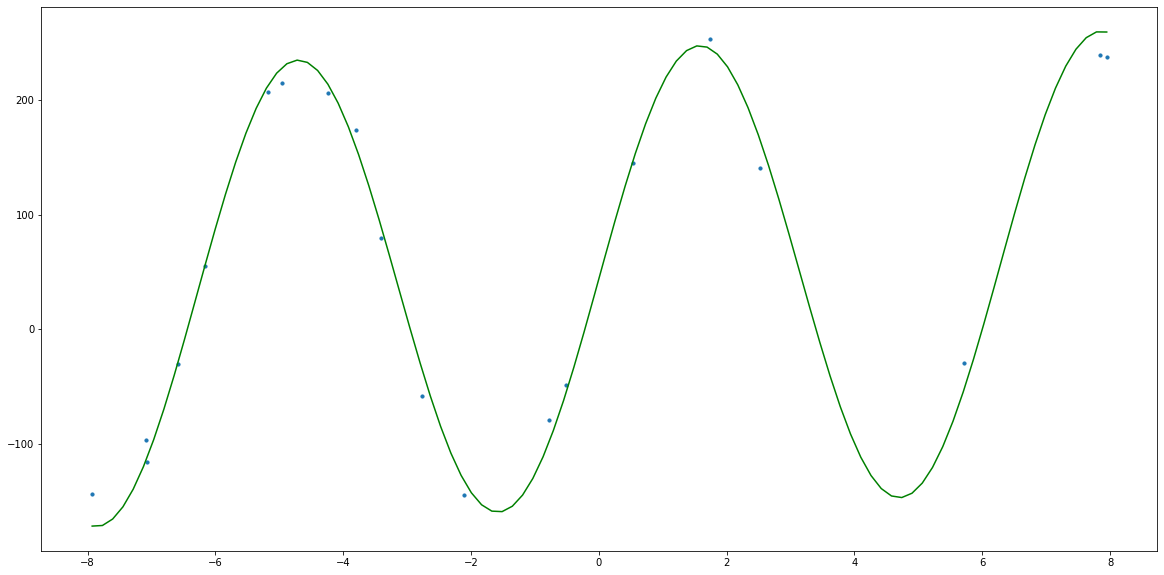

In [ ]:
f1 = Function(1, f_dim1_1, [2, 200, 44])
data1 = f1.get_data_set(max_f_deviation = 30)
data2 = f1.get_data_set(max_f_deviation = 0)
make_big_points_and_gr(data1, f1, "График двумерной функции")

In [ ]:
# Тем не менее, минимизировать нам надо функцию ошибки
def deviation(fun, curr_w, data_points):
  return fun.eval_with_new_weight(data_points[:-1], curr_w) - data_points[-1]
def MSE(fun, curr_w, data_points):
  #print(deviation(fun, curr_w, data_points))
  return np.sum(np.square(deviation(fun, curr_w, data_points)))
print(MSE(f1, f1.get_start_w(), data1))
print(MSE(f1, f1.get_start_w(), data2)) #второй результат очень логичен, если задуматься

4915.774130477428
0.0


## ***3. 1. Методы Gauss-Newton и Powell Dog Leg, сравнение со старыми методами***

Наконец приступаем к методам.

Хотим минимизировать MSE, правда ли можем воспользоваться методами? \
MSE = ∑(f(x_i, w) - y_i)^2. Можно ли её представить в виде f(w)= ∑(r_i(w))^2. \
Очевидно, что да: r_i(w) = f(x_i, w) - y_i. \
Значит, функций r_i столько же, сколько точек в датасете.

In [ ]:
def one_coord_grad(fun, curr_w, data_points, i, delta = EPS): # градиент r_j по w_i
    w_delta = curr_w.copy()
    w_delta[i] += delta
    return (deviation(fun, w_delta, data_points) - deviation(fun, curr_w, data_points)) / delta


# Возвращает матрицу частных производных r_i по w_j
def j(fun, w, data_points):
  # для каждой точки, как для определённого r_i, строим вектор([dr_i/dw_1, dr_i/dw_2...]) =>
  # матрица
  # [dr_1/dw_1, dr_1/dw_2, dr_1/dw_3 ... ]
  # [dr_2/dw_1, dr_2/dw_2, dr_2/dw_3 ... ]
  # [dr_3/dw_1, dr_3/dw_2, dr_3/dw_3 ... ]
  # [... ]
  return np.array([[one_coord_grad(fun, w, point, i) for i in range(len(w))] for point in np.transpose(data_points)])

'''
Принимает:
data_points - набор точек, до которых хотим минимизировать расстояние
fun - объект Function
'''
def descent(data_points, fun, make_new_w, start_w = None, max_iterations = 3000, eps = EPS, dop_params = None):
  w_iter = []
  if(start_w == None):
    start_w = np.ones((fun.get_param_size())) / 10
  w_iter.append(start_w)
  i = 1
  while (i < max_iterations):
    make_new_w(w_iter, fun, data_points, dop_params)
    if(len(w_iter) > 1 and abs(MSE(fun, w_iter[-1], data_points) - MSE(fun, w_iter[-2], data_points)) < eps):
      break
    i += 1
  print("Количество итераций равно: ", i)
  return w_iter

> ## **Gauss-Newton**




Формула для направления, в котором мы пойдём берётся из метода Ньютона. В нём мы расписываем:\
f(x + p) ≃ f(x) + ∇f(x) \* p + p.T ∇^2f(x) \* p (разложение в ряд Тейлора).\
=> (ищем минимум дифференциируя по p) p = -∇^2f(x_^(-1)) \* ∇f(x) \
А т.к. мы хотим минимизировать f(w)= ∑(r_i(w))^2, при взятии градиента мы получим равенство ∇f = 2J.T \* r и ∇^2 f_ij = H_ij = 2 ∑(dr_i/dw_j \* dr_i/dw_k + r_i \* d^2r_i/dw_k).\
В Гессиане слагаемое со второй производной сравнительно мало для функций близких к квадратичным, поэтому можем его опустить и считать, что H = ∇^2f ≃ 2 \* J.T \* J. \
Тогда направление минимума p = -H^(-1) \* ∇f ≃ - (2 \* J.T \* J)^(-1) \* 2J.T \* r = - (J.T \* J)^(-1) \* J.T \* r

 

In [ ]:
def gauss_newton_iter(w_iter, fun, data_points, dop_params = None):
  curr_w = w_iter[-1]
  J = j(fun, curr_w, data_points) # матрица всех частных производных
  alpha = 1
  new_w = curr_w - alpha * ln.inv(J.T @ J) @ J.T @ deviation(fun, curr_w, data_points) # то, что было написано в объяснении
  w_iter.append(new_w)

# Можно добавить в формулу более умное alpha, например делать поиск с условиями Вольфе

def gauss_newton(data_points, fun, start_w = None, max_iterations = 300, eps = EPS):
  return descent(data_points, fun, gauss_newton_iter,start_w, max_iterations, eps)

Количество итераций равно:  2
[  1.59469059 190.1576253   42.70650858] [2, 200, 44]
3576.8156496377237 4915.774130477428


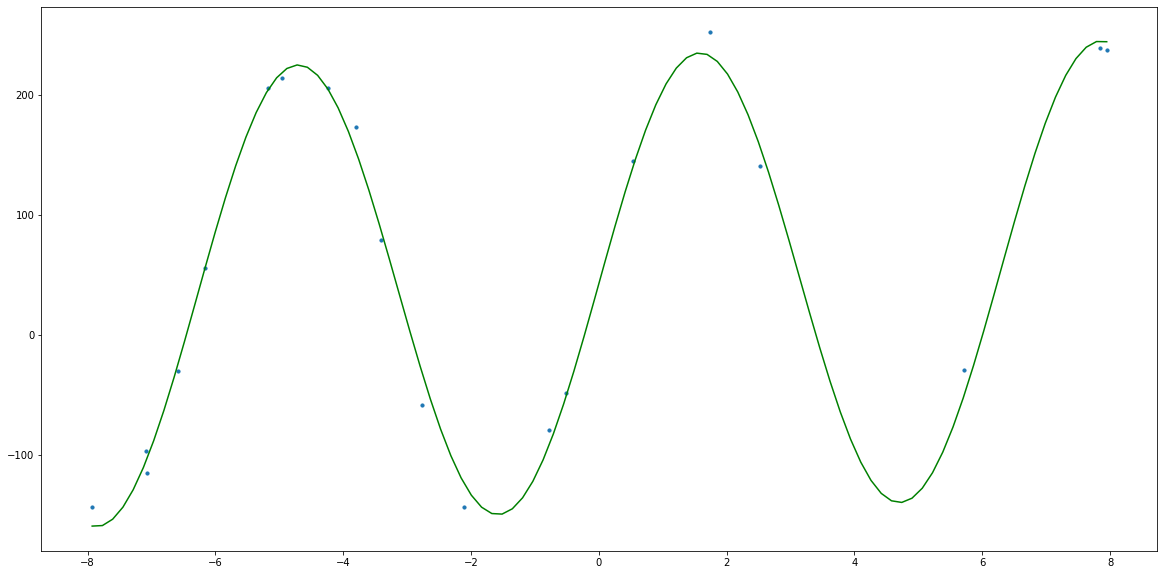

In [ ]:
w_iter1 = gauss_newton(data1, f1)
res_f1 = Function(1, f_dim1_1, w_iter1[-1])
print(w_iter1[-1], f1.get_start_w())
print(MSE(res_f1, w_iter1[-1], data1), MSE(f1, f1.get_start_w(), data1))
make_big_points_and_gr(data1, res_f1, "График приближённой функции")

Количество итераций равно:  2
[  2. 200.  44.] [2, 200, 44]
8.70902439363997e-28 0.0


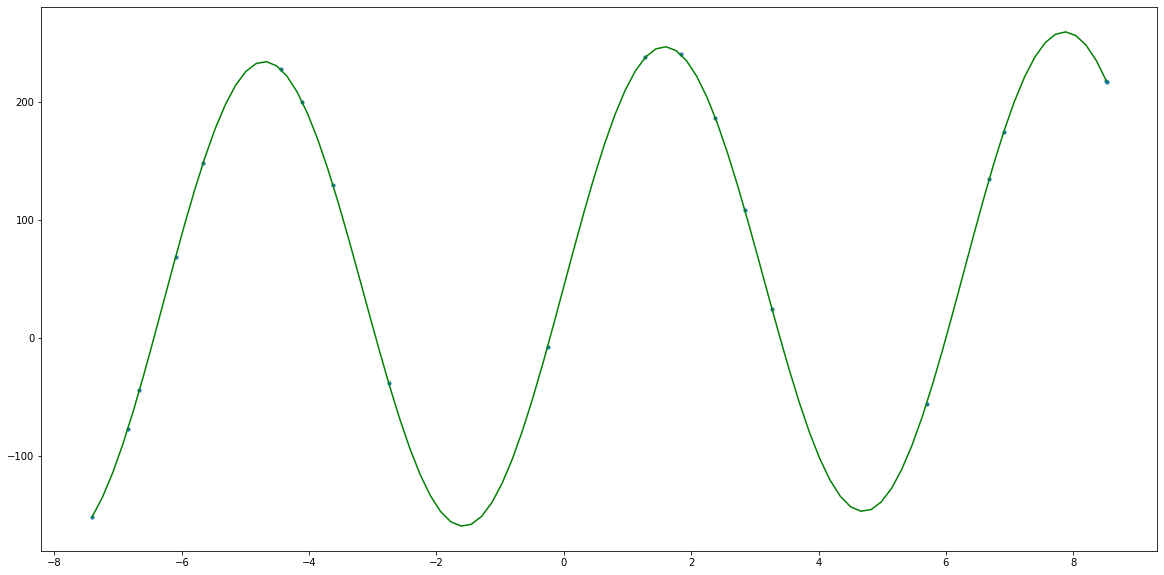

In [ ]:
w_iter1 = gauss_newton(data2, f1)
res_f1 = Function(1, f_dim1_1, w_iter1[-1])
print(w_iter1[-1], f1.get_start_w())
print(MSE(res_f1, w_iter1[-1], data2), MSE(f1, f1.get_start_w(), data2))
make_big_points_and_gr(data2, res_f1, "График приближённой функции")

> ## **Powell Dog Leg** ##





 Проблемы Гаусса-Ньютона:
 1. Приходится обращать матрицу, которая может быть вырожденной. А ещё она должна быть положительно определённой.
 2. Метод Гаусса-Ньютона сходится в области, где функция близка к квадратичной. Значит на удалении от минимума, метод Гаусса-Ньютона может сходиться медленнее, чем градиентный спуск.
Хотим скомбинировать градиентный спуск и Гаусса-Ньютона.

Подход с доверительными регионами: в данном регионе приближение ведёт себя адекватно, например, если приближаем функцию к квадратичной. Преполагается, что приближение работает в окрестности точки, в какой-то сфере. Тогда можно искать минимум в этой сфере, и при попадании в новую точку разбираться, что делать дальше.

Траекторию поиска минимума можно приблизить двумя прямыми: одна вдоль обратного градиента, вторая к минимуму. Именно из-за этого и пошло название.  \
Первая точка собачьей ноги A = -∇f.T \* ∇f / (∇f.T \* H \* ∇f) \* ∇f (Это было на лекции при разложении в ряд Тейлора f(x + α \* p) и поиске минимума). B = -H^(-1) \* ∇f - результат поиска в квадратичной модели.

Квадратичная модель функции: m(p) = f(x_k) + ∇f(x_k).T \* p + 1/2 p.T \* H \* p.\
Ищем минимум этой модели, но в доверительном регионе: m(p) ->  min, |p| < δ.
Алгоритм:
Если точка B лежит внутри доверительного региона, идём туда. Если нет, то ищем пересечение между ломаной и сферой.

![c003297eff614311831b21011ca99f06[2].png](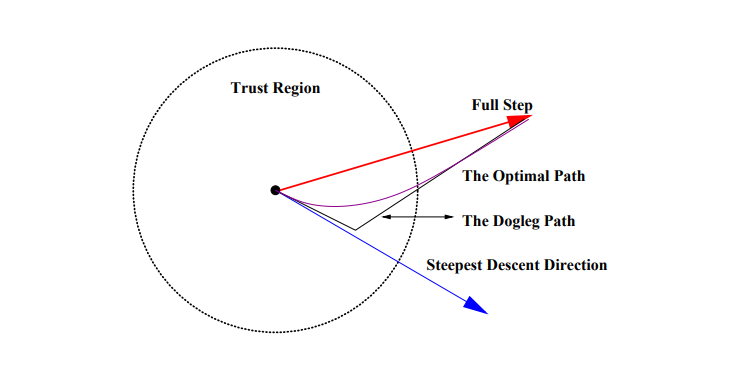)

In [ ]:
def dist(vec):
  return math.sqrt(np.sum(np.square(vec)))

def m(fun, grad, B, curr_w, data_points):
  def m_inner(p):
    if(p is 0):
      return MSE(fun, curr_w, data_points)
    return MSE(fun, curr_w, data_points) + grad.T @ p + 1/2 * p.T @ B @ p
  return m_inner

def powell_dog_leg_iter(w_iter, fun, data_points, dop_params = []):
  curr_w = w_iter[-1]
  global delta
  d = delta
  J = j(fun, curr_w, data_points)
  curr_deviation = deviation(fun, curr_w, data_points) 
  grad = 2 * J.T @ curr_deviation
  B = 2 * J.T @ J
  curr_m = m(fun, grad, B, curr_w, data_points)

  try:
    pB = - ln.inv(B) @ grad
    pB_dist = dist(pB)
  except:
    pB_dist = float('inf')
  #Если минимум внутри доверительного региона, то берём его
  if (pB_dist < d):
    p = pB
  else:
    pA = - (grad.T @ grad / (grad.T @ B @ grad)) * grad
    pA_dist = dist(pA)
    if (pA_dist > d):
      p = d * pA / pA_dist
    else:
      if(pB_dist == float('inf')):
        delta = d / 4
        return
      # Нужно найти tau такое, что |p| < delta, m(p) -> min
      tau = (-2 *(pB-pA) @ pA + 2 * dist(pB-pA) * d) / ((pB-pA)@(pB-pA))
      p = pA + tau * (pB - pA)
  new_w = curr_w + p
  ro = (MSE(fun, curr_w, data_points) - MSE(fun, new_w, data_points)) / (curr_m(0) - curr_m(p))
  #print(ro)
  if(ro < 1/4):
    delta = d/4
  elif(ro > 3/4 and dist(p) == d):
    delta = 2*d
  else:
    delta = d
  w_iter.append(new_w)

def powell_dog_leg(data_points, fun, start_w = None, max_iterations = 300, eps = EPS):
  return descent(data_points, fun, powell_dog_leg_iter, start_w, max_iterations, eps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in double_scalars


Количество итераций равно:  6
[  1.59469059 190.1576253   42.70650858] [2, 200, 44]
3576.8156496377214 4915.774130477428


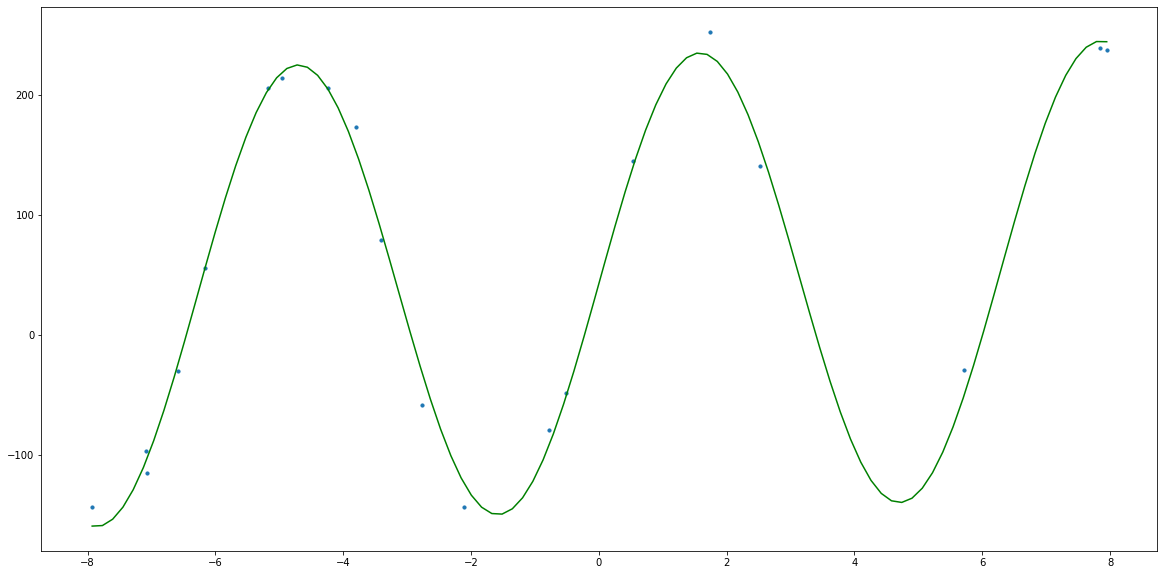

In [ ]:
delta = 10
w_iter1 = powell_dog_leg(data1, f1)
res_f2 = Function(1, f_dim1_1, w_iter1[-1])
print(w_iter1[-1], f1.get_start_w())
print(MSE(res_f2, w_iter1[-1], data1), MSE(f1, f1.get_start_w(), data1))
make_big_points_and_gr(data1, res_f2, "График приближённой функции")

Количество итераций равно:  6
[  2. 200.  44.] [2, 200, 44]
2.133079887717616e-27 0.0


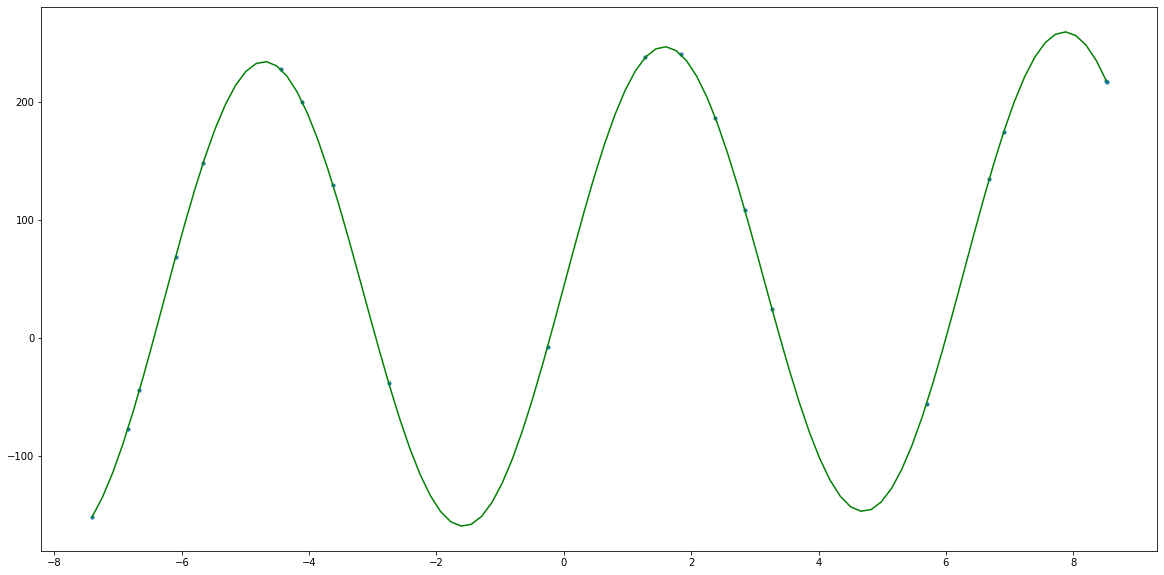

In [ ]:
w_iter1 = powell_dog_leg(data2, f1)
res_f2 = Function(1, f_dim1_1, w_iter1[-1])
print(w_iter1[-1], f1.get_start_w())
print(MSE(res_f2, w_iter1[-1], data2), MSE(f1, f1.get_start_w(), data2))
make_big_points_and_gr(data2, res_f2, "График приближённой функции")

> ## **Чем Powell Dog Leg лучше Gauss-Newton?** ##

Проблемы возникают, если Якобиан вырожденный, то есть его определитель равен 0. Чтобы избежать проблем мы делаем шаги в доверительной области.

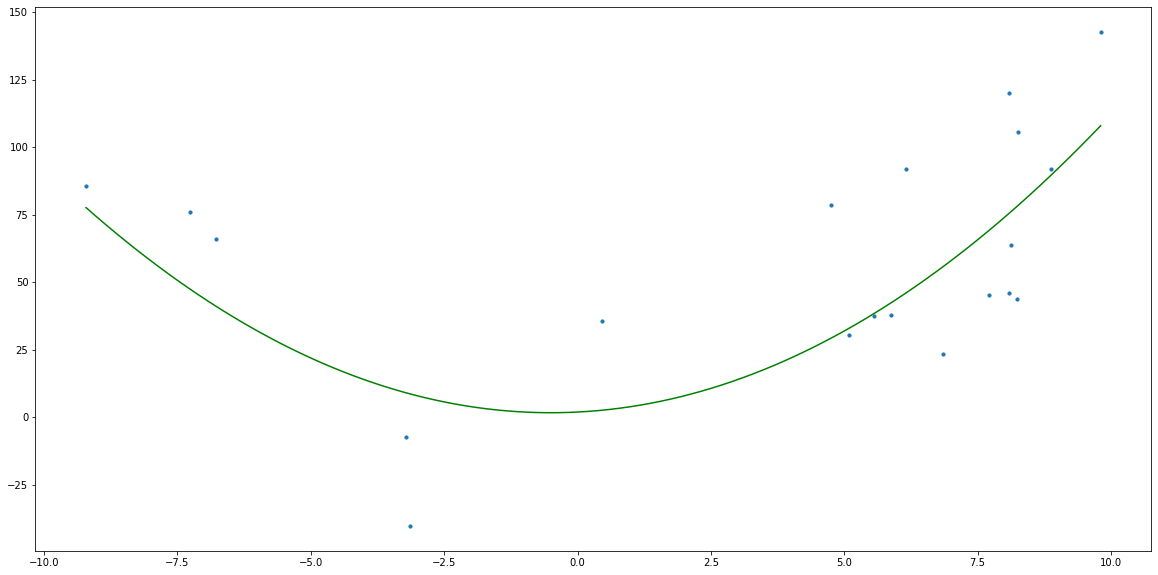

In [ ]:
def f_dim1_2(x, w):
  return w[0] + w[1] * x[0] + w[2] * x[0] * x[0]
f2 = Function(1, f_dim1_2, [2, 1, 1, 50])
data2_1 = f2.get_data_set(max_f_deviation = 50)
data2_2 = f2.get_data_set(max_f_deviation = 0)
make_big_points_and_gr(data2_1, f2, "График двумерной функции")

In [ ]:
def show_gr(fun, data, method):
  w_iter = method(data, fun)
  res = Function(1, fun.f, w_iter[-1])
  print(w_iter[-1], fun.get_start_w())
  print(MSE(res, w_iter[-1], data), MSE(fun, fun.get_start_w(), data))
  make_big_points_and_gr(data, res, "График приближённой функции")

Problem with J
Количество итераций равно:  300
[0.2410409  0.61499233 1.14910308 0.1       ] [2, 1, 1, 50]
16990.690804318485 17581.0457477298


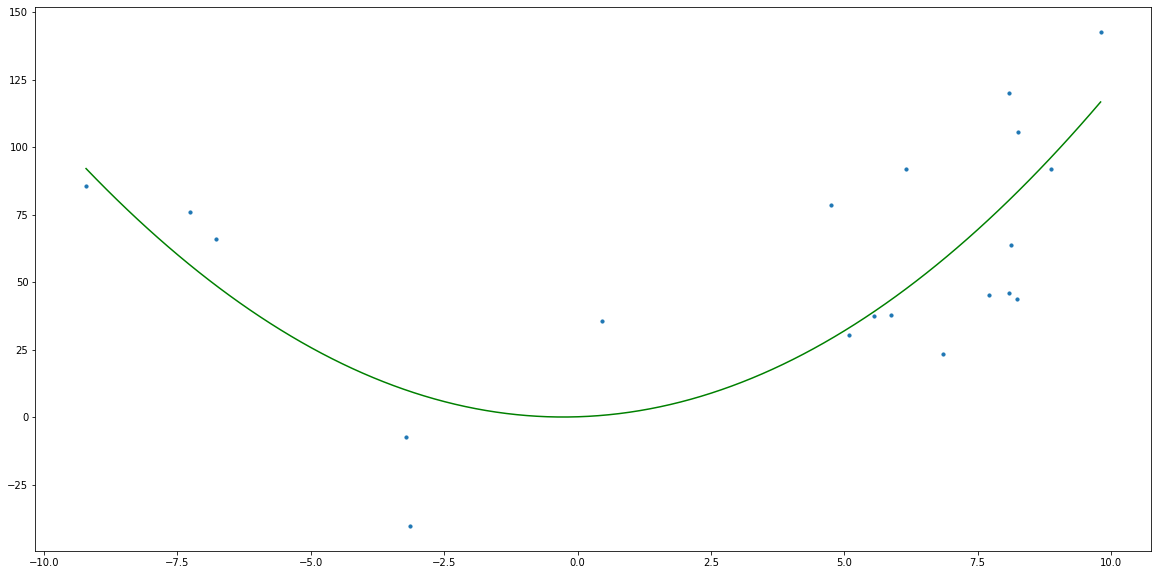

In [ ]:
try:
  show_gr(f2, data2_1, gauss_newton)
except:
  print('Problem with J')
show_gr(f2, data2_1, powell_dog_leg)

Problem with J
Количество итераций равно:  300
[0.47610115 1.00148122 1.03189124 0.1       ] [2, 1, 1, 50]
22.73508827704905 0.0


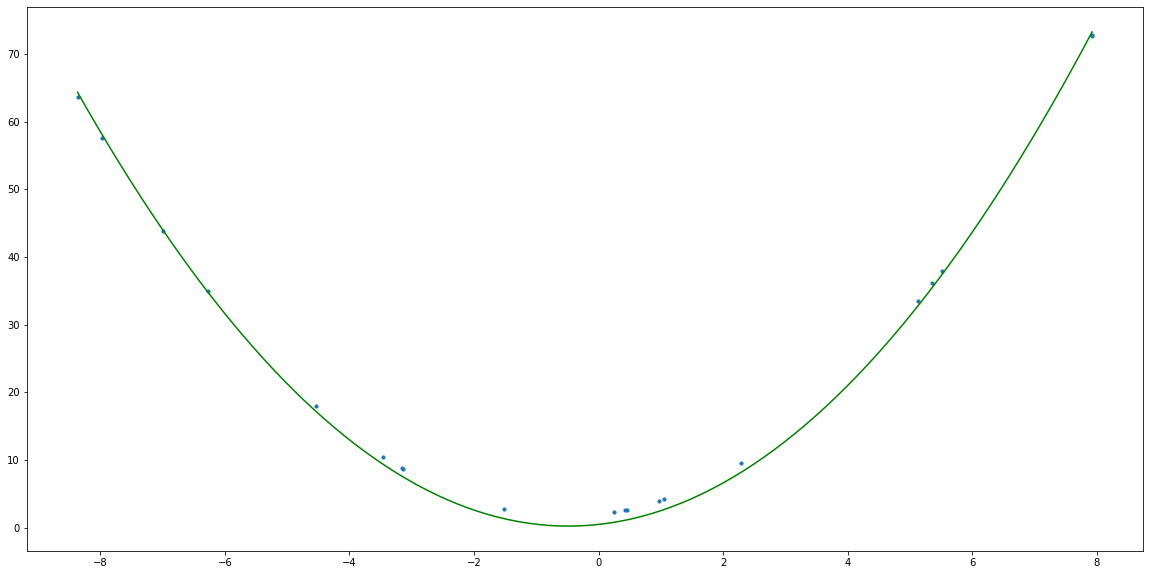

In [ ]:
try:
  show_gr(f2, data2_2, gauss_newton)
except:
  print('Problem with J')
show_gr(f2, data2_2, powell_dog_leg)

> ## **Сравнение со старыми методами** ##

Попробуем запустить нашу функцию для линейной регрессии и старого датасета.

In [ ]:
file_wh = "file_1.txt" #https://drive.google.com/file/d/1TeLCr1wtKUKHefQWoMb3OEV-XZQeIwoE/view?usp=sharing
def get_wh_points():
  f = open(file_wh, 'r')
  points_wh = []
  for f_str in f.readlines():
    if not f_str.isspace():
      _, x, y = map(float, f_str.split())
      points_wh.append(np.array([x, y]))
  return points_wh
def get_simple_points(size = 30):
  points = []
  try: 
    f = open("simple_file.txt", 'r')
    for f_str in f.readlines():
      if not f_str.isspace():
        _, x, y = map(float, f_str.split())
        points.append(np.array([x, y]))
  except:
    for i in range(size):
      points.append(np.array([i / 10, i / 10]))
  return points

Количество итераций равно:  2
[   4.18697048 -156.09139004] [0, 0]
5282.220724322272 838153.0976
Количество итераций равно:  47
[   4.18697048 -156.09138979] [0, 0]
5282.22072432227 838153.0976


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in double_scalars


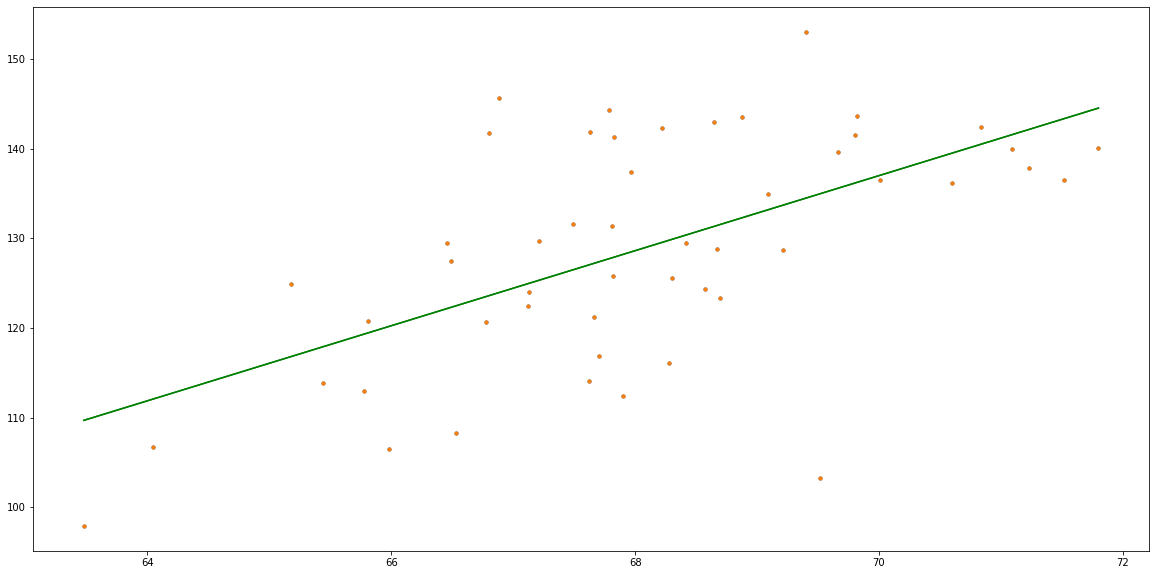

In [ ]:
def f_linear(x, w):
  return w[0] * x[0] + w[1]
f3 = Function(1, f_linear, [0, 0])
data3 = np.transpose(np.array(get_wh_points()))
show_gr(f3, data3, gauss_newton)
show_gr(f3, data3, powell_dog_leg)

Количество итераций равно:  2
[1.00000000e+00 5.18700956e-17] [0, 0]
1.5016458462465228e-32 85.55
Количество итераций равно:  3
[ 1.00000000e+00 -2.72183849e-17] [0, 0]
2.2815844301662928e-33 85.55


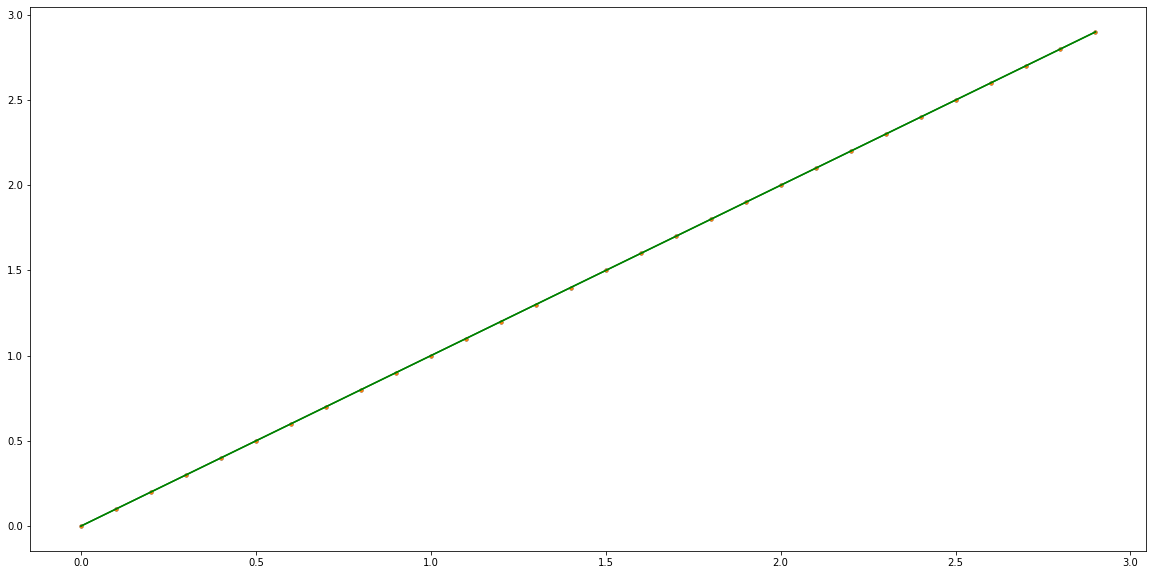

In [ ]:
data4 = np.transpose(np.array(get_simple_points()))
show_gr(f3, data4, gauss_newton)
show_gr(f3, data4, powell_dog_leg)

In [ ]:
table = pd.DataFrame([[300, 260], ['5?', 2], [2, 2], ['прим. 100', 3]],
                    index=pd.Index(['SGD MiniBatch', 'AdaGrad', 'Gauss-Newton', 'Powell Dog Leg'], name='Models:'),
                    columns=['Кол-во итераций на рандомном наборе точек', 'Кол-во итераций на линейном'])
table.style

,Кол-во итераций на рандомном наборе точек,Кол-во итераций на линейном
Models:,,
SGD MiniBatch,300,260
AdaGrad,5?,2
Gauss-Newton,2,2
Powell Dog Leg,прим. 100,3


**Вывод:** Эффективнее всего работает Гаусс-Ньютон, DogLeg помогает нам обезопасить ситуацию, но немного замедляет работу.

## ***3. 2. Метод BFGS и сравнение со старыми методами***

Теперь нам нужно минимизировать различные функции.

In [ ]:
def f_dim2_1(x):
  return x[0]**2 - x[0]*x[1] + x[1]**2 + 9*x[0] - 6*x[1] + 20

def grad_f1(x):
    return np.array([2 * x[0] - x[1] + 9, -x[0] + 2*x[1] - 6])

def f_dim2_2(x):
  return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2 # ф-я Розенброка

def grad_f2(x):
  return np.array([-400*x[0]*(x[1] - x[0]**2) + 2 * x[0] - 2, -200*(x[0]**2) + 200 * x[1]])

f2_1 = Function(2, f_dim2_1)
f2_2 = Function(2, f_dim2_2)

def grad_for_func(func):
  def grad_inner(x):
    gradient = []
    delta_x = x.copy()
    for i in range(len(x)):
      delta_x[i] = x[i] + EPS
      gradient.append((func.eval(delta_x) - func.eval(x))/EPS)
      delta_x[i] = x[i]
    return np.array(gradient)
  return grad_inner

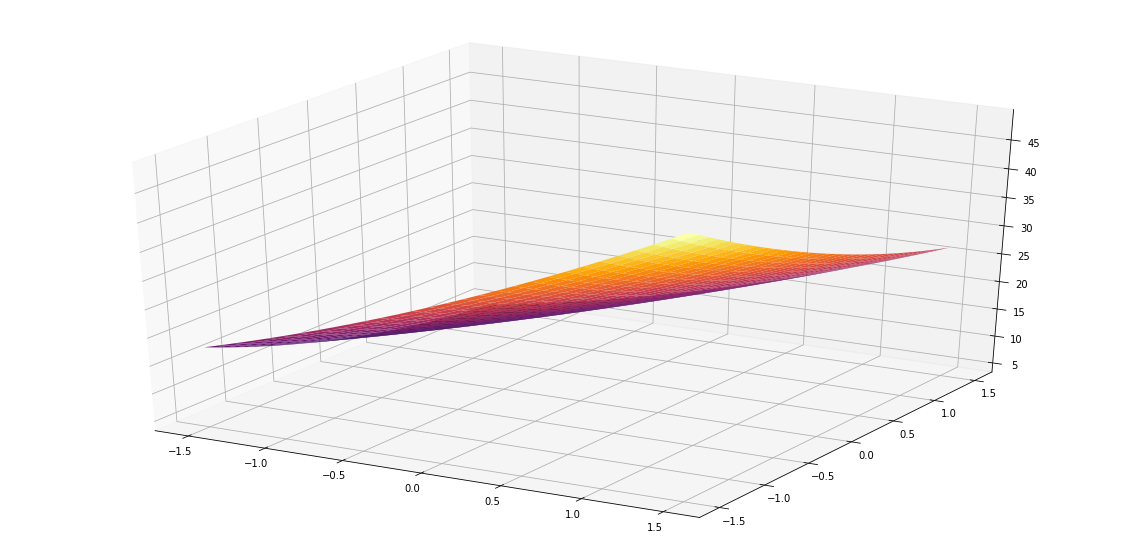

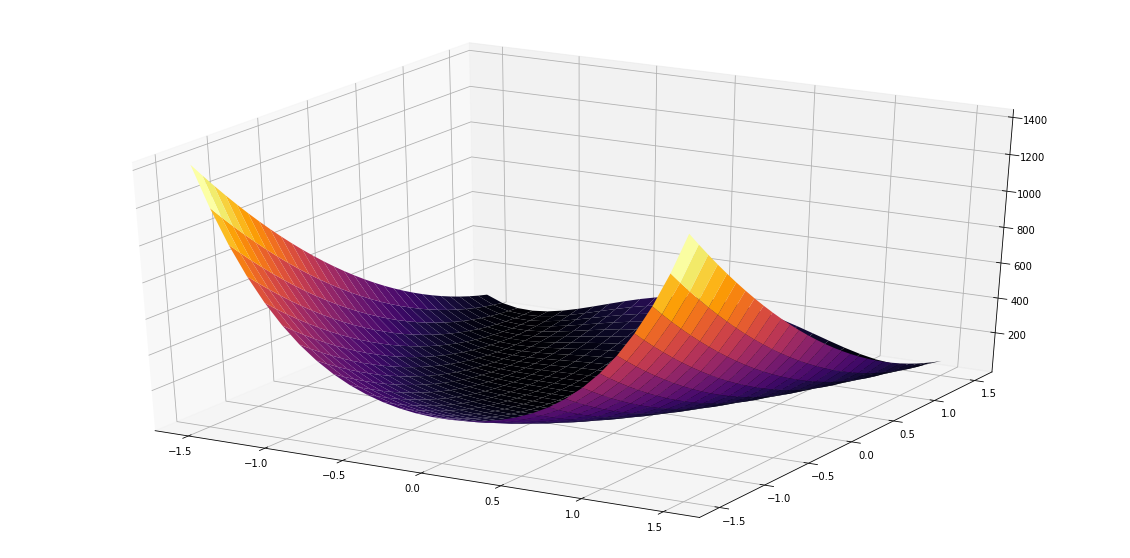

In [ ]:
gr_3d(f2_1)
gr_3d(f2_2)

> ## **BFGS**




Гессиан никуда не влезет при больших размерностях, поэтому перейдём к квазиньютоновским методам, в которых вместо настоящего Гессиана используется приближение.\
Была квадратичная модель m_k(p) = f_k + ∇f_k.T \* p + 1/2 \* p.T \* B_k \* p. \
Накладываем требования на Гессиан: правильный градиент на последнем и на предпоследнем шаге. \
Градиент модели в новой точке: ∇m_k+1(-α_k \* p_k) = ∇f_k+1 - α_k \* B_k+1 \* p_k = ∇f_k. => B_k+1 \* α_k \* p_k = ∇f_k+1 - ∇f_k.\
α_k \* p_k = s_k = x_k+1 - x_k\
∇f_k+1 - ∇f_k = y_k

Значит, условия такие:\
B_k+1 \* s_k = y_k, s_k.T \* y_k > 0\
Значит, нам надо делать шаги с условиями Вольфе. \
Также стоит помнить, что есть много подходящих B_k+1.\
Поэтому добавляем условие, что мы выбираем матрицу минимально отличающуюся по норме от предыдущей.\
Из этого получили формулу, используя норму Фробениуса.


На каждом шаге считаем примерное значение Гессиана. А также используем поиск с условиями Вольфе, потому что формула BFGS имеет самокорректирующиеся свойства. Если матрица $H$ не верно оценивает кривизну функции и если эта плохая оценка замедляет алгоритм, тогда апроксимация гессиана стремится исправить ситуацию за несколько шагов.


In [ ]:
def BFGS(f, grad, start_x = None, max_iterations = 300, eps = EPS, beta = 1):
  x_iter = []
  if(start_x is None):
    start_x = np.zeros((f.dim))
  print(start_x)
  x_iter.append(start_x)
  E = np.eye(f.dim, dtype=int)
  H = beta * E # обратный Гессиан
  i = 1
  while (i < max_iterations):
    p = - H @ grad(x_iter[-1]) # направление 
    #поиск с условиями Вольфе
    alpha = sp.optimize.line_search(f.eval, grad, x_iter[-1], p, maxiter = 4000, c1 = 0.0001, c2 = 0.9)[0]
    x_iter.append(x_iter[-1] + alpha * p)
    s = x_iter[-1] - x_iter[-2]
    y = grad(x_iter[-1]) - grad(x_iter[-2])

    #считаем примерное значение Гессиана по BFGS
    ro = 1.0 / (y.T @ s)
    A1 = E - ro * s[:, np.newaxis] * y[np.newaxis, :]
    A2 = E - ro * y[:, np.newaxis] * s[np.newaxis, :]
    H = A1 @ H @ A2 + (ro * s[:, np.newaxis] * s[np.newaxis, :])
    if(abs(f.eval(x_iter[i]) - f.eval(x_iter[i - 1])) < eps):
      break
    i += 1
  print("Количество итераций равно: ", i)
  return np.array(x_iter)

[0. 0.]
Количество итераций равно:  4
[-4.  1.]
Значение функции в приближённой точке экстремума: -1.0
Время: not evaluated


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in multiply


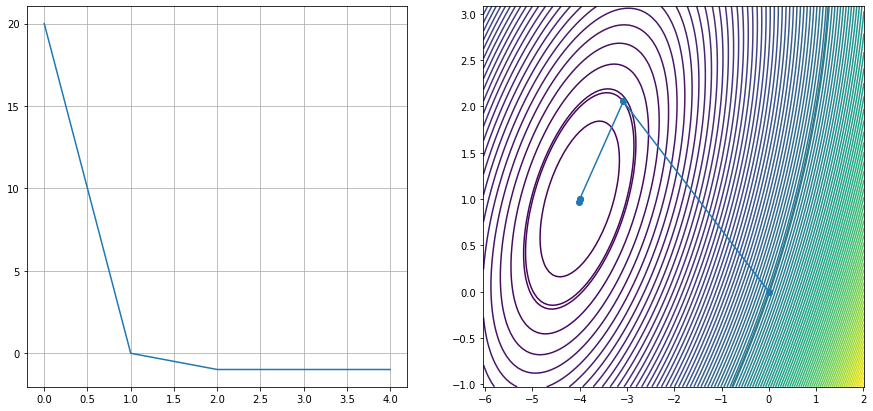

In [ ]:
points = BFGS(f2_1, grad_f1)
print(points[-1])
gr_of_grad_one(f2_1, points, "not evaluated")

[0. 0.]
Количество итераций равно:  17
Значение функции в приближённой точке экстремума: 7.3333992726974465e-09
Время: not evaluated


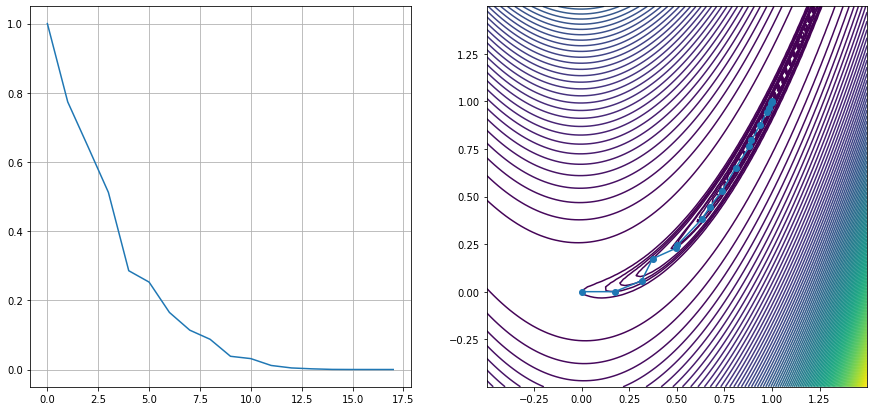

In [ ]:
points = BFGS(f2_2, grad_f2)
gr_of_grad_one(f2_2, points, "not evaluated")

[0. 0.]
Количество итераций равно:  17
Значение функции в приближённой точке экстремума: 7.3333992726974465e-09
Время: not evaluated


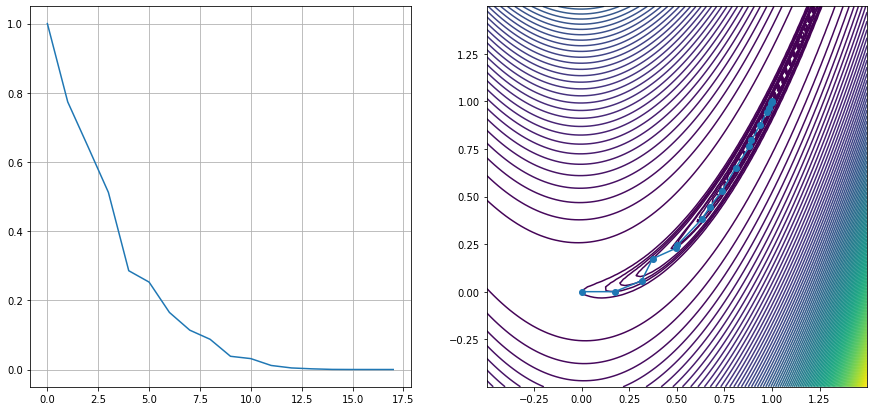

In [ ]:
points = BFGS(f2_2, grad_f2)
gr_of_grad_one(f2_2, points, "not evaluated")

[1.5 0.5]
Количество итераций равно:  37
Значение функции в приближённой точке экстремума: 4.1853757222052925e-10
Время: not evaluated


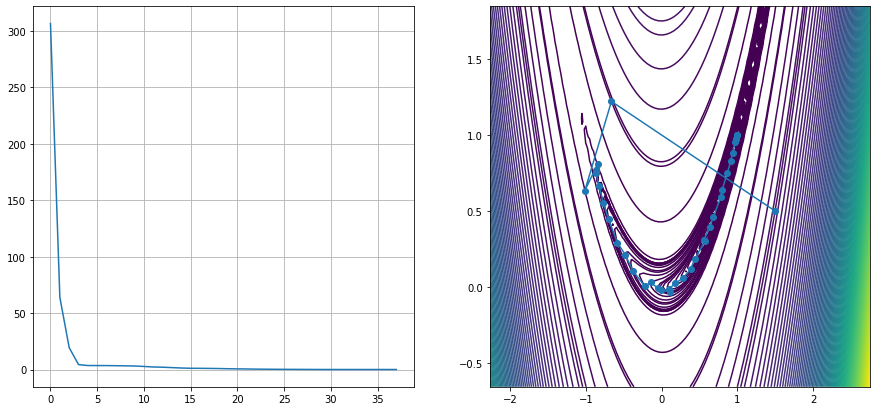

In [ ]:
points = BFGS(f2_2, grad_f2, np.array([1.5, 0.5]))
gr_of_grad_one(f2_2, points, "not evaluated")

[1.5 0.5]
Количество итераций равно:  32
Значение функции в приближённой точке экстремума: 2.016888435288435e-09
Время: not evaluated


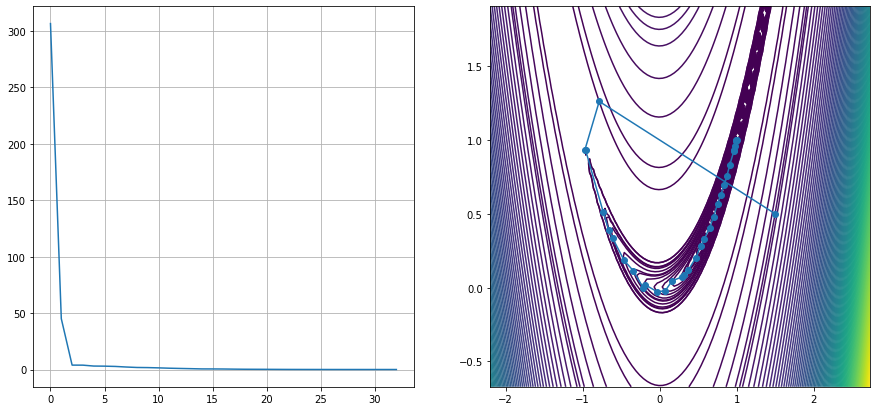

In [ ]:
points = BFGS(f2_2, grad_f2, np.array([1.5, 0.5]), beta = 0.5)
gr_of_grad_one(f2_2, points, "not evaluated")

> ## **Сравнение со старыми методами** ##

In [ ]:
table = pd.Series([800, 7, 17],
                    index=['Обычный градиентный спуск с const_lr', 'Градиентный спуск с exp_lr', 'BFGS'],
                    name = 'Количество итераций на функции Розенброка')
table

Обычный градиентный спуск с const_lr    800
Градиентный спуск с exp_lr                7
BFGS                                     17
Name: Количество итераций на функции Розенброка, dtype: int64

**Вывод:** При экспоненциальном спуске мы долго выбирали старт и хорошие коэффициенты, но BFGS всё равно работает довольно эффективно.

## ***3. 3. Метод L-BFGS***

> ## **L-BFGS**




Хотя алгоритм квазиньютоновского приближения BFGS устраняет проблему вычисления матрицы Гессе, нам все равно необходимо сохранять предыдущий Гессиан каждый раз. Это все еще не снижает нагрузку на память. Мы должны помнить, что наше первоначальное намерение выбрать квазиньютоновский метод состоит в том, чтобы уменьшить объем памяти.

In [ ]:
def L_BFGS(f, grad, start_x = None, max_iterations = 300, eps = EPS, last = 4):
  x_iter = []
  if(start_x is None):
    start_x = np.zeros((f.dim))
  #print(start_x)
  x_iter.append(start_x)
  E = np.eye(f.dim, dtype=int)
  i = 1
  s = []
  y = []
  a = []
  ro = []
  p = - E @ grad(x_iter[-1])
  #print(p)
  while (i < max_iterations):
    #поиск с условиями Вольфе
    alpha = sp.optimize.line_search(f.eval, grad, x_iter[-1], p, maxiter = 5000)[0]
    #print(alpha)
    try:
      x_iter.append(x_iter[-1] + alpha * p)
    except:
      print("Количество итераций равно: ", i)
      return np.array(x_iter)
    s.append(x_iter[-1] - x_iter[-2])
    y.append(grad(x_iter[-1]) - grad(x_iter[-2]))
    ro.append(1.0 / (y[-1].T @ s[-1]))

    if (len(s) > last):
      s.pop(0)
      y.pop(0)
      ro.pop(0)
      a.pop(0)

    q = grad(x_iter[-1])
    a.append(0)
    for k in range(1, min(i, last) + 1):
      ak = ro[-1] * s[-k].T @ q
      a[-k] = ak
      q -= a[-k] * y[-k]
    #print(s, y, ro, a)
    gamma = s[-1].T @ y[-1]/(y[-1].T @ y[-1])
    r = gamma * E @ q
    for k in range(max(-last, -i), 0):
      #print(k)
      b = ro[k] * y[k].T @ r
      r = r + s[k] * (a[k] - b)
    # r = H * grad
    p = - r / dist(r) # направление 
    #print(p)
    if(abs(f.eval(x_iter[i]) - f.eval(x_iter[i - 1])) < eps):
      break
    i += 1
  print("Количество итераций равно: ", i)
  return np.array(x_iter)

> ## **Исследование** ##

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Количество итераций равно:  13
Значение функции в приближённой точке экстремума: 0.0003375598897866596
Время: not evaluated


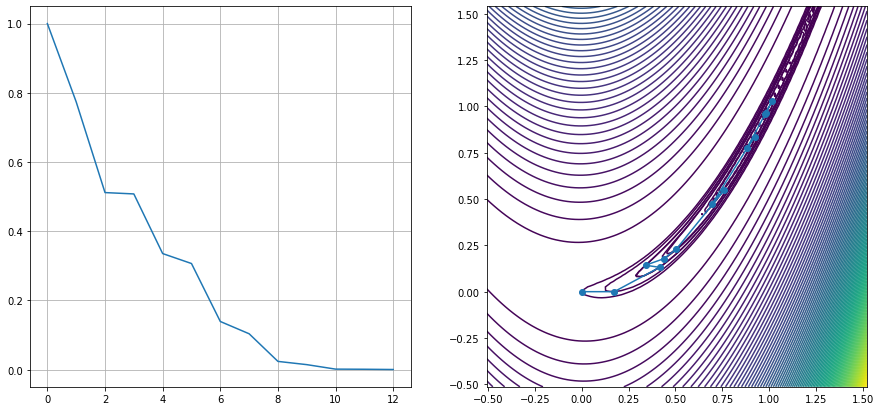

In [ ]:
points = L_BFGS(f2_2, grad_f2)
gr_of_grad_one(f2_2, points, "not evaluated")

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Количество итераций равно:  22
Значение функции в приближённой точке экстремума: 0.10611750039881504
Время: not evaluated


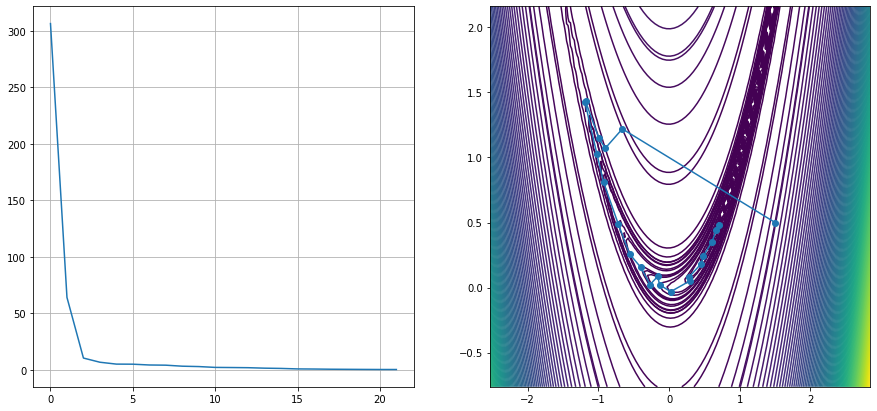

In [ ]:
points = L_BFGS(f2_2, grad_f2, np.array([1.5, 0.5]))
gr_of_grad_one(f2_2, points, "not evaluated")

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Количество итераций равно:  4
[-4.  1.]
Значение функции в приближённой точке экстремума: -0.9999999999999964
Время: not evaluated


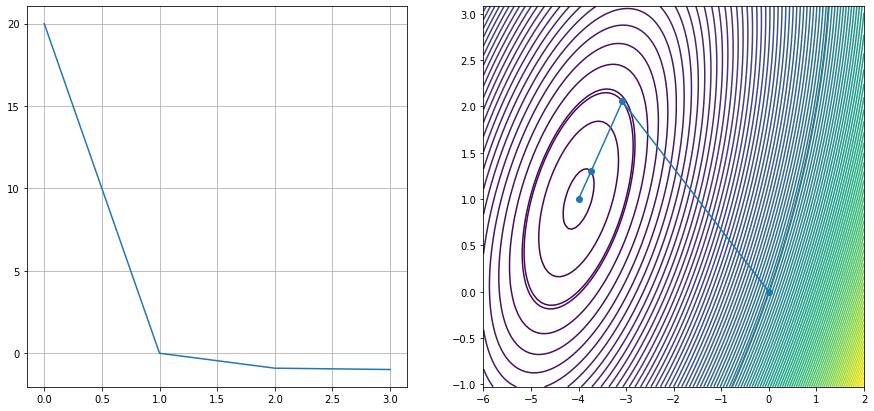

In [ ]:
points = L_BFGS(f2_1, grad_f1)
print(points[-1])
gr_of_grad_one(f2_1, points, "not evaluated")

Работает чуть менее точно, чем BFGS. Но потребляет меньше памяти, потому что не хранит Гессиан и хранит только часть предыдущий значений.

## **Источники**

https://www.wikiwand.com/en/Powell%27s_dog_leg_method#/cite_ref-powell1970_1-1


https://habr.com/ru/post/333356/

http://www.seas.ucla.edu/~vandenbe/236C/lectures/gn.pdf

https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%91%D1%80%D0%BE%D0%B9%D0%B4%D0%B5%D0%BD%D0%B0_%E2%80%94_%D0%A4%D0%BB%D0%B5%D1%82%D1%87%D0%B5%D1%80%D0%B0_%E2%80%94_%D0%93%D0%BE%D0%BB%D1%8C%D0%B4%D1%84%D0%B0%D1%80%D0%B1%D0%B0_%E2%80%94_%D0%A8%D0%B0%D0%BD%D0%BD%D0%BE

https://russianblogs.com/article/88691473439/

https://habr.com/ru/post/335224/

https://en.wikipedia.org/wiki/Limited-memory_BFGS